<a href="https://colab.research.google.com/github/sebatlab/Antaki2021/blob/main/Antaki2021_rebuttal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import itertools
import scipy.stats
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
# import statsmodels.stats.multitest
# from statsmodels.stats.contingency_tables import Table2x2
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

%matplotlib inline
plt.rcParams['svg.fonttype'] = 'none'

# Figure parameters
SMALL = 20
MEDIUM = 25
BIG = 30
MASSIVE = 60
YLABEL_PAD = 25.0
FIGSIZE_DEFAULT = (26, 16)
LINEWIDTH = 5

# PRSice vs. SBayesR

In [ ]:
# Figure 2A Supplement PRSice vs. SBayesR
""" Analysis """
# SBayesR
df = pd.read_csv("/content/r2_table.csv", sep = ",")
# Reformat data
df[["R2_type", "Sex"]] = df['text'].str.split('_', 1, expand = True)
df['Sex'] = df['Sex'].replace({"both": "Female & Male", "female": "Female", "male": "Male"})
# To get the error bars, Danny uses the upper confidence interval value (shortcut?)
df['ci'] = df['ci_upper'] - df['nagelkerke_R2_val']
df["ci_lower_adj"] = df["nagelkerke_R2_val"] - df["ci_lower"]
df["ci_upper_adj"] = df["ci_upper"] - df["nagelkerke_R2_val"]
df = df[df["Sex"] == "Female & Male"].reset_index(drop = True)
df = df.reindex([1, 0, 3, 8, 5, 7, 6, 4, 2]).reset_index(drop = True)

df["Model"] = "SBayesR"
df_sbr = df

prs_categories = ["ptdt.asd.dev", "ptdt.scz.dev", "ptdt.ea.dev", "prs"]
df_sbr = df_sbr[df_sbr["R2_type"].isin(prs_categories)].reset_index(drop = True)

ci_lower_upper_sbr = df_sbr[['ci_lower_adj', 'ci_upper_adj']].apply(tuple, axis = 1).tolist()
ci_lower_upper_sbr = np.array(ci_lower_upper_sbr).T.tolist()


# PRSice
""" Analysis """
df = pd.read_csv("/content/r2_table.prsice.csv", sep = ",")
# Reformat data
df[["R2_type", "Sex"]] = df['text'].str.split('_', 1, expand = True)
df['Sex'] = df['Sex'].replace({"both": "Female & Male", "female": "Female", "male": "Male"})
# To get the error bars, Danny uses the upper confidence interval value (shortcut?)
df['ci'] = df['ci_upper'] - df['nagelkerke_R2_val']
df["ci_lower_adj"] = df["nagelkerke_R2_val"] - df["ci_lower"]
df["ci_upper_adj"] = df["ci_upper"] - df["nagelkerke_R2_val"]
df = df[df["Sex"] == "Female & Male"].reset_index(drop = True)
df = df.reindex([1, 0, 3, 8, 5, 7, 6, 4, 2]).reset_index(drop = True)

df["Model"] = "PRSice"
df_prsice = df

prs_categories = ["ptdt.asd.dev", "ptdt.scz.dev", "ptdt.ea.dev", "prs"]
df_prsice = df_prsice[df_prsice["R2_type"].isin(prs_categories)].reset_index(drop = True)

ci_lower_upper_prsice = df_prsice[['ci_lower_adj', 'ci_upper_adj']].apply(tuple, axis = 1).tolist()
ci_lower_upper_prsice = np.array(ci_lower_upper_prsice).T.tolist()


# Combine asymmetric confidence intervals (error bars)
ci_lower_upper_sbr    = np.array(ci_lower_upper_sbr)
ci_lower_upper_prsice = np.array(ci_lower_upper_prsice)
ci_lower_upper_both = np.zeros([2, 2, 4])
ci_lower_upper_both[0,:,:] = ci_lower_upper_sbr
ci_lower_upper_both[1,:,:] = ci_lower_upper_prsice

""" Plotting """
dfm = df_sbr.merge(df_prsice, how = "left", on = ["text", "R2_type", "Sex"])

f, ax = plt.subplots(1, 1, figsize = FIGSIZE_DEFAULT)

colors = ['mediumaquamarine', 'bisque']
width = 0.5
dfm.plot.bar(
    x = "R2_type",
    y = ["nagelkerke_R2_val_x", "nagelkerke_R2_val_y"],
    yerr = ci_lower_upper_both,
    label = ["SBayesR", "PRSice"],
    color = colors,
    edgecolor = "k",
    width = width,
    linewidth = LINEWIDTH - 1,
    ax = ax
)

leg = ax.legend(loc = 2, fontsize = MASSIVE - 10)

ax.set_ylabel('r$^2$', fontsize = MASSIVE, color = "black")
ax.set_xlabel('')
xlabs = [
    '$PS_{ASD}$','$PS_{SCZ}$','$PS_{EA}$',
    '$PS_{Combined}$'
]
ax.set_xticklabels(xlabs, rotation = 60)

plt.yticks(fontsize = MASSIVE, color = "black")
plt.xticks(fontsize = MASSIVE, color = "black")

sns.set_context('talk')
sns.set_style('ticks')
sns.despine(ax = ax)

f.savefig("r2.sbayes_vs_prsice.png", bbox_inches = "tight")
f.savefig("r2.sbayes_vs_prsice.svg", bbox_inches = "tight")
f.savefig("r2.sbayes_vs_prsice.pdf", bbox_inches = "tight")

# SPARK Quality Control metrics

In [ ]:
# Supplemental figure SPARK QC analysis
""" Analysis """
def make_df(df, col, cohort = "SPARK"):
  df_tmp = df.dropna(subset = [col])
  if cohort:
    df_tmp = df_tmp[df_tmp["Cohort"] == cohort]

  cas = df_tmp[df_tmp["Phenotype"] == 1]
  ctl = df_tmp[df_tmp["Phenotype"] == 0]

  # Get means
  cas_mean = cas[col].mean()
  ctl_mean = ctl[col].mean()
  # Get standard errors (of the means)
  cas_sem = cas[col].sem()
  ctl_sem = ctl[col].sem()
  # Get confidence intervals
  confidence = 0.95
  cas_ci = cas_sem * scipy.stats.t.ppf((1 + confidence)/2., cas.shape[0] )
  ctl_ci = ctl_sem * scipy.stats.t.ppf((1 + confidence)/2., ctl.shape[0] )
  # Get number of cases and controls with more than 0 of specified column
  num_cas = cas[cas[col] > 0].shape[0]
  num_ctl = ctl[ctl[col] > 0].shape[0]
  # Sum column value
  cas_sum = sum(cas[col])
  ctl_sum = sum(ctl[col])
  # Frequency
  cas_freq = cas_sum/cas.shape[0]
  ctl_freq = ctl_sum/ctl.shape[0]

  p_val = scipy.stats.ttest_ind(cas[col], ctl[col])[1]

  if cohort:
    return pd.DataFrame([[cohort, col, cas_mean, cas_ci, num_cas, cas_sum, cas_freq, ctl_mean, ctl_ci, num_ctl, ctl_sum, ctl_freq, p_val]], columns = ["Cohort", "QC_Metric", "ASD Mean", "ASD 95% CI", "ASD Samples", "ASD Mutations", "ASD Frequency", "Control Mean", "Control 95% CI", "Control Samples", "Control Mutations", "Control Frequency", "P-value"])
  
  return pd.DataFrame([[col, cas_mean, cas_ci, num_cas, cas_sum, cas_freq, ctl_mean, ctl_ci, num_ctl, ctl_sum, ctl_freq, p_val]], columns = ["QC_Metric", "ASD Mean", "ASD 95% CI", "ASD Samples", "ASD Mutations", "ASD Frequency", "Control Mean", "Control 95% CI", "Control Samples", "Control Mutations", "Control Frequency", "P-value"])

def plot_pvals(ax, index, pval, text_buffer = 0, line_buffer = 0):
  # if pval > 0.05: return
  pval_asterisk = ""
  if pval < 0.001:  pval_asterisk =  "***"
  elif pval < 0.01: pval_asterisk =  "**"
  elif pval < 0.05: pval_asterisk =  "*"

  # Properties of the bar
  xy = ax.patches[index].xy
  x_start = xy[0]
  width = ax.patches[index].get_width()
  x_end = x_start + width
  height = ax.patches[index].get_height()
  midpoint = (x_start + x_end)*0.5

  ax.plot([midpoint, midpoint, midpoint + width, midpoint + width], [height + line_buffer, height + 0.005 + line_buffer, height + 0.005 + line_buffer, height + line_buffer], linewidth = 2, color = "black")
  ax.text(x = x_end, y = height + text_buffer, s = "{:.2e}".format(pval), ha = "center", va = "center", fontsize = MASSIVE, color = "black")


# Get summary data table
df = pd.read_csv("/content/SummaryGeneticData_REACH_SSC_SPARK.SBayesR.csv", sep=",")
df = df[["FID", "IID", "Phenotype", "Sex", "Cohort", "Family Type", "Cases in Family", "EUR Ancestry", "dnMIS", "dnLOF"]]
df = df[df["Family Type"] == "trio"]

# Get SPARK DNMs (after filtering and intersecting with Iossifov's exonic region)
# df_filtered_dnms = pd.read_csv("/content/df_filtered_dnms.tsv", sep = "\t")
df_filtered_dnms = pd.read_csv("/content/df_filtered_dnms.iossifov.tsv", sep = "\t")

# Merge dataframes (summary data table) with df_filtered_dnms (DNM counts per type)
df_dnms_merge = pd.merge(df, df_filtered_dnms, on = ["IID", "Sex", "Phenotype", "Cohort"], how = "left")

# Fill NAs with zeros (they are 0 for dnLOF and dnMIS)
df_dnms_merge['dnLoF_Iossifov'] = df_dnms_merge['lof_count'].fillna(value = 0)
df_dnms_merge['dnMis_Iossifov'] = df_dnms_merge['mis_count'].fillna(value = 0)
df_dnms_merge['dnSyn_Iossifov'] = df_dnms_merge['syn_count'].fillna(value = 0)

# We're only looking at SPARK DNMs for this part of the analysis
df_spark_dnms = df_dnms_merge[df_dnms_merge["Cohort"] == "SPARK"]

# Get quality control metrics for SPARK
df_spark_info = pd.read_csv("df.spark_info.csv")
df_spark_info['Sex'] = df_spark_info['Sex'].replace({1: 0, 2: 1})
df_spark_info['Phenotype'] = df_spark_info['Phenotype'].replace({1: 0, 2: 1})

# Merge df_spark_info (quality control metrics) with the merged dataframe
df_spark_dnms_info = df_spark_dnms.merge(df_spark_info, on = ["IID", "FID", "Phenotype", "Sex"])

# Make dataframes for each of the quality control metrics
df_spark_pct = make_df(df_spark_dnms_info, col = "PCT_Targeted_bases_20x")
df_spark_ti_tv = make_df(df_spark_dnms_info, col = "ti_tv")
df_spark_het_hom_ratio = make_df(df_spark_dnms_info, col = "het_hom_ratio")
df_spark_father_age_at_birth = make_df(df_spark_dnms_info, col = "father.age.at.birth.z")

# Concatenate the quality control metric dataframes
df_spark_qc = pd.concat([df_spark_pct, df_spark_ti_tv, df_spark_het_hom_ratio])

# Correlate dnSyn and Het/Hom
scipy.stats.pearsonr(df_spark_dnms_info['dnSyn_Iossifov'], df_spark_dnms_info['het_hom_ratio'])

""" Plotting """
f, ax = plt.subplots(1, 1, figsize = FIGSIZE_DEFAULT)

colors = ['mediumaquamarine', 'bisque']
width = 0.5
df_spark_qc.plot.bar(
    x = "QC_Metric",
    y = ["ASD Mean", "Control Mean"],
    yerr = df_spark_qc[["ASD 95% CI", "Control 95% CI"]].values.T,
    label = ["SPARK ASD", "SPARK Control"],
    color = colors,
    edgecolor = "k",
    width = width,
    linewidth = LINEWIDTH - 1,
    ax = ax
)

leg = ax.legend(loc = 1, fontsize = MASSIVE - 10)

ax.set_ylabel('Quality Control metrics', color = "black", fontsize = MASSIVE)
ax.set_xlabel('')
df_spark_qc_labels = ["PCT\nTargeted bases 20x", "Ti/Tv", "Het/Hom"]
ax.set_xticklabels(df_spark_qc_labels, rotation = 0, fontsize = MASSIVE)

plt.yticks(fontsize = MASSIVE, color = "black")

sns.set_context('talk')
sns.set_style('ticks')
sns.despine(ax = ax)

plot_pvals(ax, index = 0, pval = df_spark_qc["P-value"].values[0], line_buffer = 0.10, text_buffer = 0.20)
plot_pvals(ax, index = 1, pval = df_spark_qc["P-value"].values[1], line_buffer = 0.10, text_buffer = 0.20)
plot_pvals(ax, index = 2, pval = df_spark_qc["P-value"].values[2], line_buffer = 0.10, text_buffer = 0.20)



f.savefig("rebuttal.spark.qc.png", bbox_inches = "tight")
f.savefig("rebuttal.spark.qc.svg", bbox_inches = "tight")
f.savefig("rebuttal.spark.qc.pdf", bbox_inches = "tight")

# SPARK Paternal Ages

In [ ]:
# Supplemental figure SPARK Paternal Age analysis
""" Analysis """
def make_df(df, col, cohort = "SPARK"):
  df_tmp = df.dropna(subset = [col])
  if cohort:
    df_tmp = df_tmp[df_tmp["Cohort"] == cohort]

  cas = df_tmp[df_tmp["Phenotype"] == 1]
  ctl = df_tmp[df_tmp["Phenotype"] == 0]

  # Get means
  cas_mean = cas[col].mean()
  ctl_mean = ctl[col].mean()
  # Get standard errors (of the means)
  cas_sem = cas[col].sem()
  ctl_sem = ctl[col].sem()
  # Get confidence intervals
  confidence = 0.95
  cas_ci = cas_sem * scipy.stats.t.ppf((1 + confidence)/2., cas.shape[0])
  ctl_ci = ctl_sem * scipy.stats.t.ppf((1 + confidence)/2., ctl.shape[0])

  p_val = scipy.stats.ttest_ind(cas[col], ctl[col])[1]
  if cohort:
    return pd.DataFrame([[cohort, col, cas_mean, cas_ci, ctl_mean, ctl_ci, p_val]], columns = ["Cohort", "QC_Metric", "ASD Mean", "ASD 95% CI", "Control Mean", "Control 95% CI", "P-value"])

  return pd.DataFrame([[col, cas_mean, cas_ci, ctl_mean, ctl_ci, p_val]], columns = ["QC_Metric", "ASD Mean", "ASD 95% CI", "Control Mean", "Control 95% CI", "P-value"])



# Get summary data table
df = pd.read_csv("/content/SummaryGeneticData_REACH_SSC_SPARK.SBayesR.csv", sep=",")
df = df[["FID", "IID", "Phenotype", "Sex", "Cohort", "Family Type", "Cases in Family", "EUR Ancestry", "dnMIS", "dnLOF"]]
df = df[df["Family Type"] == "trio"]
# Exclude the hypermutators
df = df[~df["IID"].isin(exclude_iids)]

# Get DNMs (after filtering and intersecting with Iossifov's exonic region)
# df_filtered_dnms = pd.read_csv("/content/df_filtered_dnms.tsv", sep = "\t")
df_filtered_dnms = pd.read_csv("/content/df_filtered_dnms.iossifov.tsv", sep = "\t")

# Merge df (summary data table) with df_filtered_dnms (DNM counts per type)
df_dnms_merge = df.merge(df_filtered_dnms, on = ["IID", "Sex", "Phenotype", "Cohort"], how = "left")
# Fill NAs with zeros (they are 0 for dnLOF and dnMIS)
df_dnms_merge['lof_count'] = df_dnms_merge['lof_count'].fillna(value = 0)
df_dnms_merge['mis_count'] = df_dnms_merge['mis_count'].fillna(value = 0)
df_dnms_merge['syn_count'] = df_dnms_merge['syn_count'].fillna(value = 0)

# Get parental ages
df_pa = pd.read_csv("/content/parental_ages_reach_ssc_spark.csv")
df_pa = df_pa[["IID", "Father_IID", "Mother_IID", "FATHER_AGE", "MOTHER_AGE", "cohort"]]
df_pa = df_pa.rename(columns = {"cohort": "Cohort"})

# Merge
df_dnms_merge = df_dnms_merge.merge(df_pa, on = ["IID", "Cohort"])

# Split by cohort
df_dnms_reach = df_dnms_merge[df_dnms_merge["Cohort"] == "REACH"]
df_dnms_spark = df_dnms_merge[df_dnms_merge["Cohort"] == "SPARK"]
df_dnms_ssc   = df_dnms_merge[df_dnms_merge["Cohort"] == "SSC"]

# Make dataframes for fathers' ages
df_reach_father_age_at_birth = make_df(df_dnms_reach, col = "FATHER_AGE", cohort = "REACH")
df_spark_father_age_at_birth = make_df(df_dnms_spark, col = "FATHER_AGE", cohort = "SPARK")
df_ssc_father_age_at_birth   = make_df(df_dnms_ssc,   col = "FATHER_AGE", cohort = "SSC")

""" Plotting """
f, ax = plt.subplots(1, 1, figsize = FIGSIZE_DEFAULT)

colors = ['mediumaquamarine', 'bisque']
width = 0.5
df_spark_father_age_at_birth.plot.bar(
    x = "QC_Metric",
    y = ["ASD Mean", "Control Mean"],
    yerr = df_spark_father_age_at_birth[["ASD 95% CI", "Control 95% CI"]].values.T,
    label = ["SPARK ASD", "SPARK Control"],
    color = colors,
    edgecolor = "k",
    width = width,
    linewidth = LINEWIDTH - 1,
    legend = None,
    ax = ax
)

ax.set_ylabel('Paternal age (at birth)', color = "black", fontsize = MASSIVE)
ax.set_xlabel('')
df_spark_father_age_at_birth_labels = ["Paternal age\n(at birth)"]
ax.set_xticklabels(df_spark_father_age_at_birth_labels, rotation = 0, fontsize = MASSIVE)

plt.yticks(fontsize = MASSIVE, color = "black")

sns.set_context('talk')
sns.set_style('ticks')
sns.despine(ax = ax)

f.savefig("rebuttal.spark.paternal_age.png", bbox_inches = "tight")
f.savefig("rebuttal.spark.paternal_age.svg", bbox_inches = "tight")
f.savefig("rebuttal.spark.paternal_age.pdf", bbox_inches = "tight")

# Synonymous DNMs

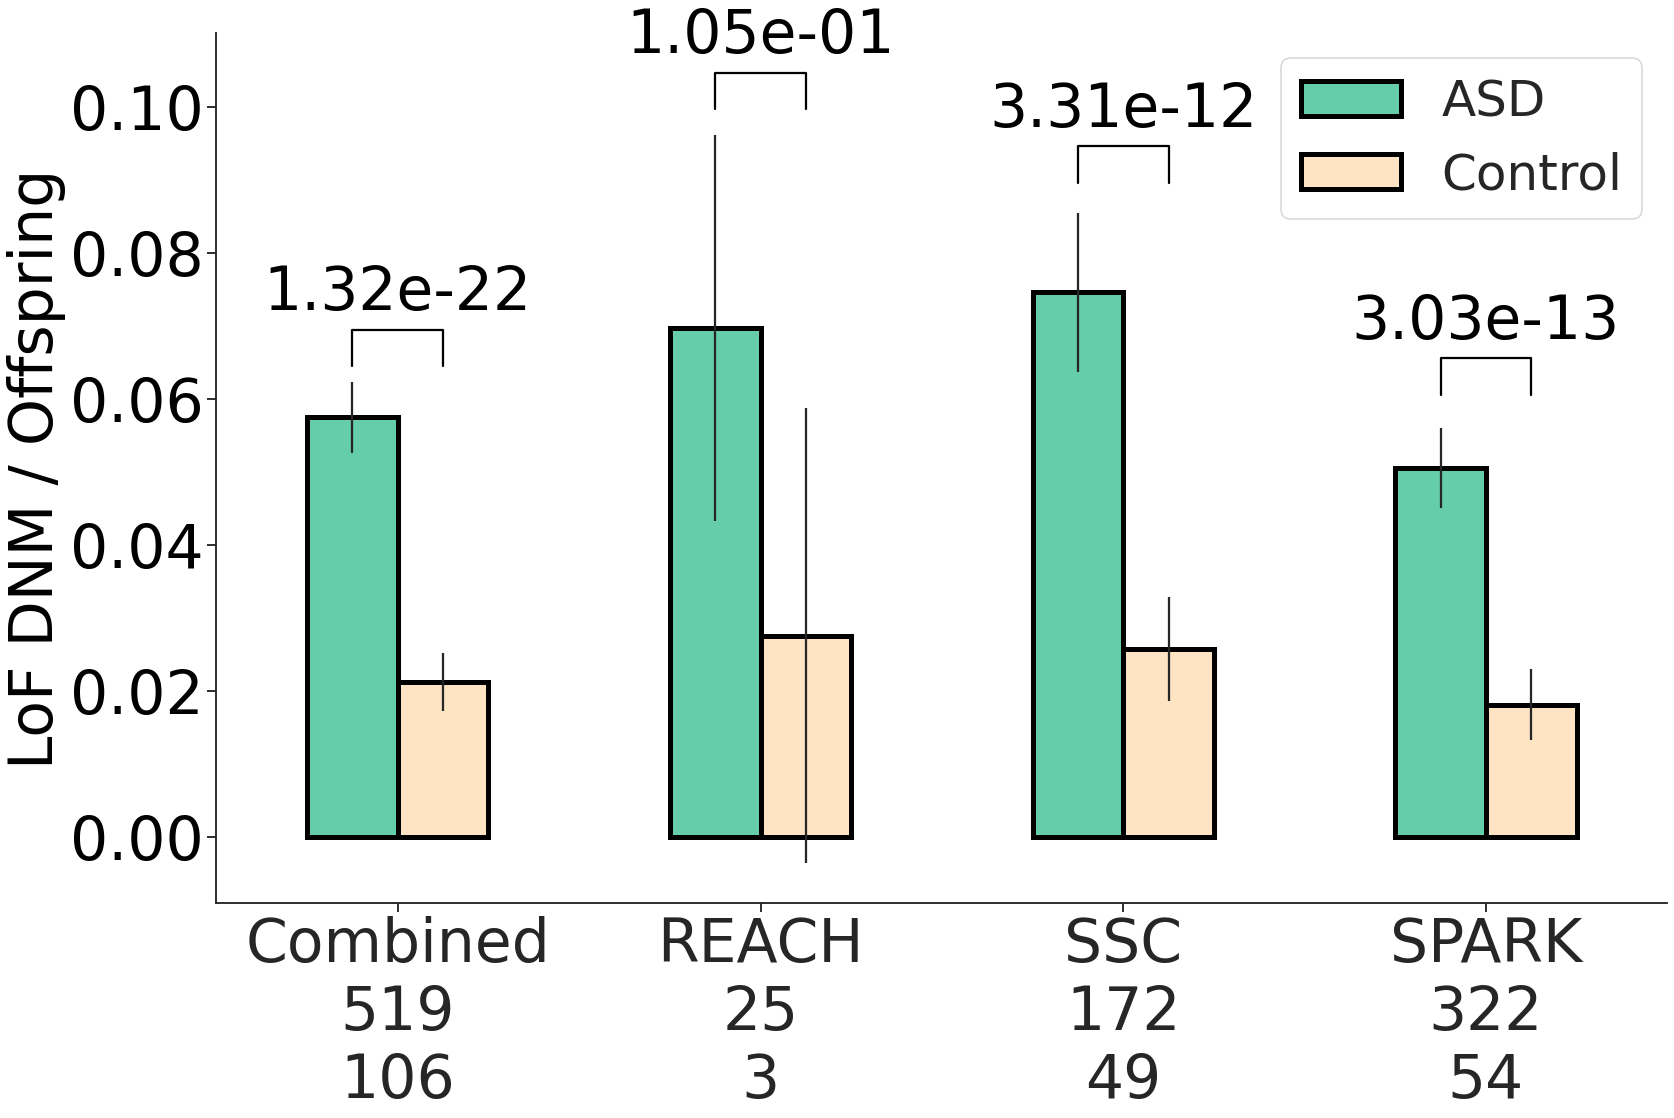

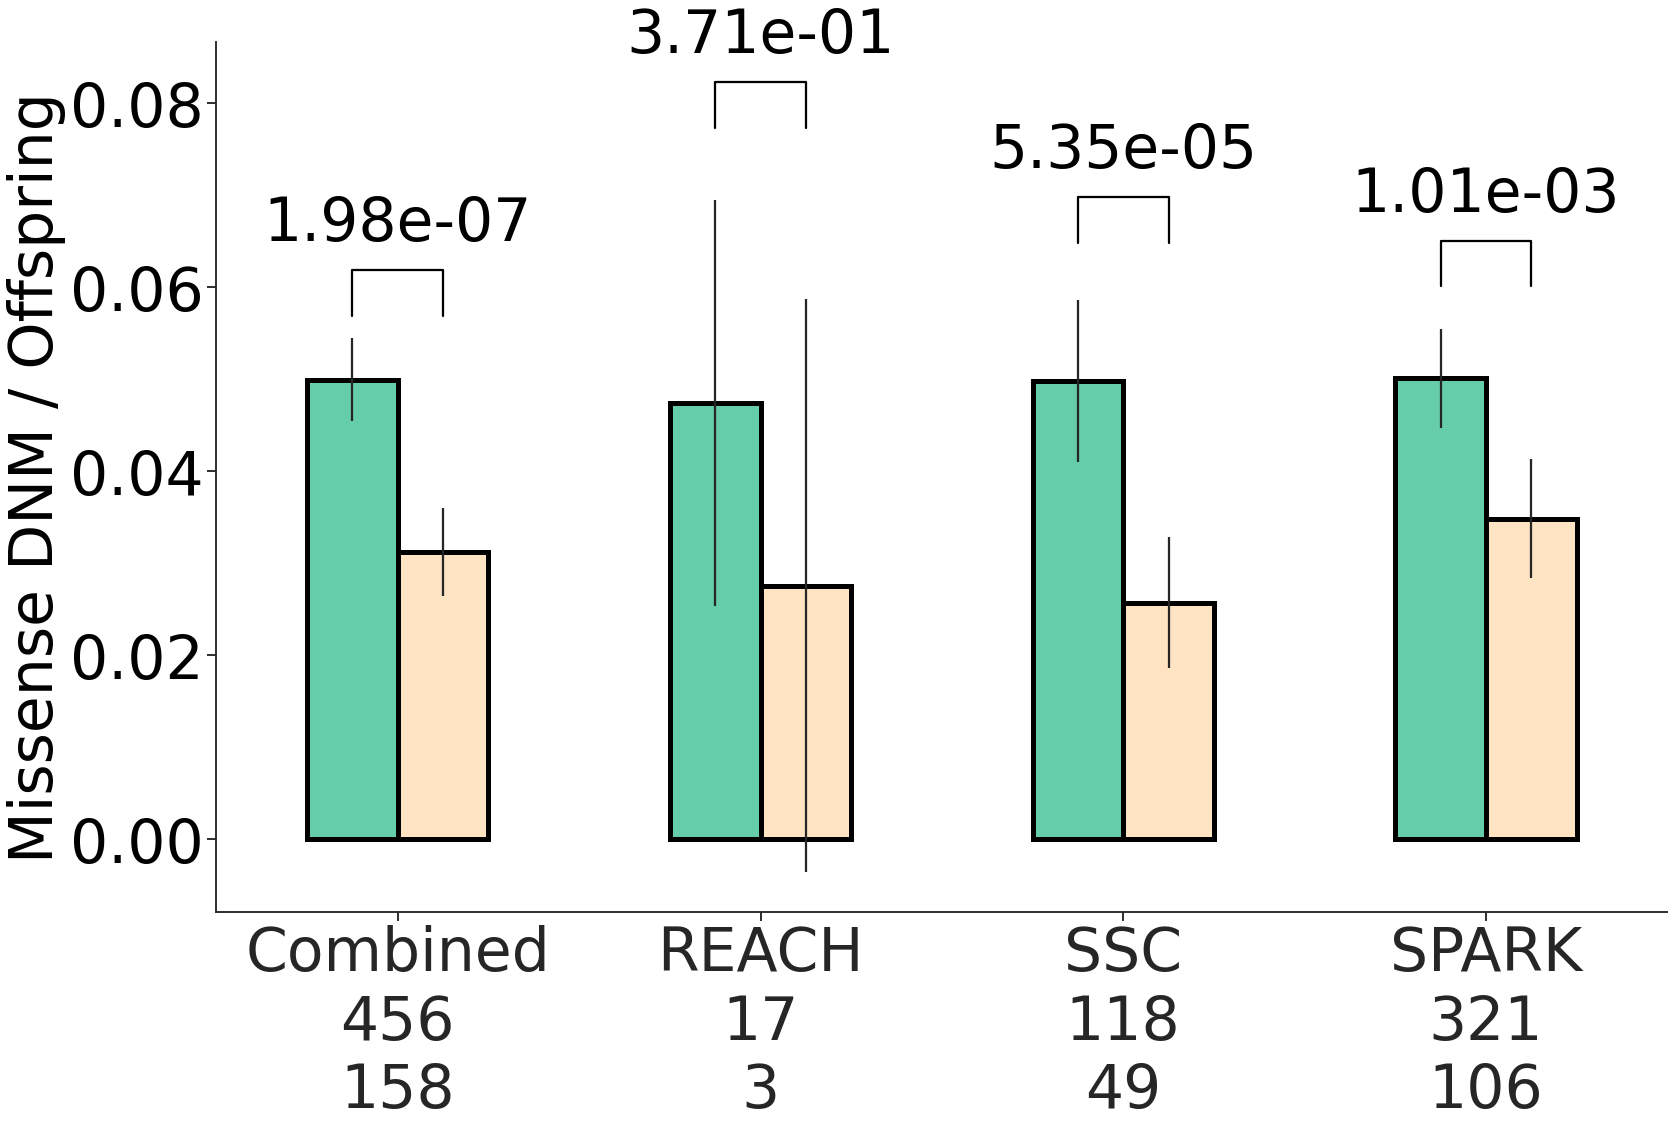

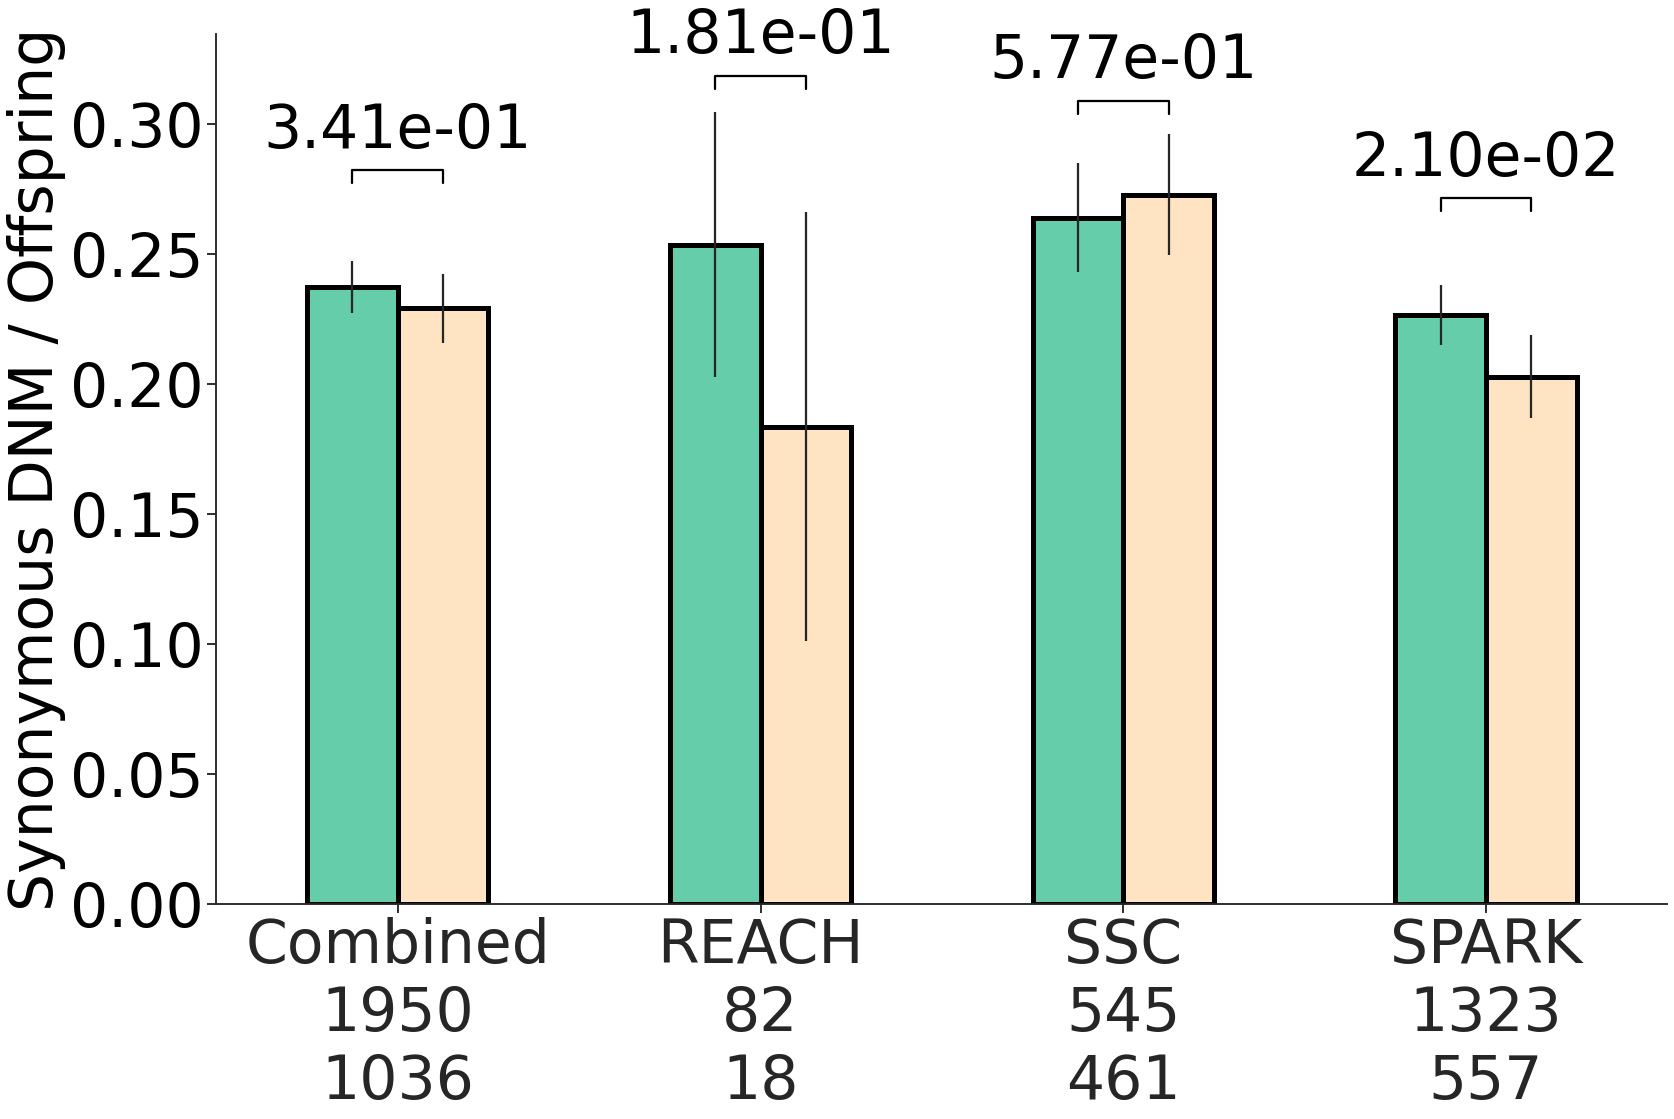

In [34]:
# Supplemental figure for DNMs by cohort (dnLoF, dnMis, dnSyn)
""" Analysis """
def make_df(df, col, cohort = None):
  df_tmp = df.dropna(subset = [col])

  if cohort:
    df_tmp = df_tmp[df_tmp["Cohort"] == cohort]

  cas = df_tmp[df_tmp["Phenotype"] == 1]
  ctl = df_tmp[df_tmp["Phenotype"] == 0]

  # Get means
  cas_mean = cas[col].mean()
  ctl_mean = ctl[col].mean()
  # Get standard errors (of the means)
  cas_sem = cas[col].sem()
  ctl_sem = ctl[col].sem()
  # Get confidence intervals
  confidence = 0.95
  cas_ci = cas_sem * scipy.stats.t.ppf((1 + confidence)/2., cas.shape[0] )
  ctl_ci = ctl_sem * scipy.stats.t.ppf((1 + confidence)/2., ctl.shape[0] )
  # Get number of cases and controls with more than 0 of specified column
  num_cas = cas[cas[col] > 0].shape[0]
  num_ctl = ctl[ctl[col] > 0].shape[0]
  # Sum column value
  cas_sum = sum(cas[col])
  ctl_sum = sum(ctl[col])
  # Frequency
  cas_freq = cas_sum/cas.shape[0]
  ctl_freq = ctl_sum/ctl.shape[0]

  p_val = scipy.stats.ttest_ind(cas[col], ctl[col])[1]

  if cohort:
    return pd.DataFrame([[cohort, col, cas_mean, cas_ci, num_cas, cas_sum, cas_freq, ctl_mean, ctl_ci, num_ctl, ctl_sum, ctl_freq, p_val]], columns = ["Cohort", "DNMs", "ASD Mean", "ASD 95% CI", "ASD Samples", "ASD Mutations", "ASD Frequency", "Control Mean", "Control 95% CI", "Control Samples", "Control Mutations", "Control Frequency", "P-value"])
  
  return pd.DataFrame([[col, cas_mean, cas_ci, num_cas, cas_sum, cas_freq, ctl_mean, ctl_ci, num_ctl, ctl_sum, ctl_freq, p_val]], columns = ["DNMs", "ASD Mean", "ASD 95% CI", "ASD Samples", "ASD Mutations", "ASD Frequency", "Control Mean", "Control 95% CI", "Control Samples", "Control Mutations", "Control Frequency", "P-value"])

# Exclude hypermutators (5 families)
exclude_iids = ["SSC00428", "SSC00796",
                "SSC12169", "SSC12150",
                "SSC10120", "SSC10135",
                "SSC06079", "SSC06086",
                "SSC10085", "SSC10090"]

# Get summary data table
df = pd.read_csv("/content/SummaryGeneticData_REACH_SSC_SPARK.SBayesR.csv", sep=",")
df = df[["FID", "IID", "Phenotype", "Sex", "Cohort", "Family Type", "Cases in Family", "EUR Ancestry", "dnMIS", "dnLOF"]]
df = df[df["Family Type"] == "trio"]
# Exclude the hypermutators
df = df[~df["IID"].isin(exclude_iids)]

# Get DNMs (after filtering and intersecting with Iossifov's exonic region)
# df_filtered_dnms = pd.read_csv("/content/df_filtered_dnms.tsv", sep = "\t")
df_filtered_dnms = pd.read_csv("/content/df_filtered_dnms.iossifov.tsv", sep = "\t")

# Merge df (summary data table) with df_filtered_dnms (DNM counts per type)
df_dnms_merge = df.merge(df_filtered_dnms, on = ["IID", "Sex", "Phenotype", "Cohort"], how = "left")

# Fill NAs with zeros (they are 0 for dnLOF and dnMIS)
df_dnms_merge['lof_count'] = df_dnms_merge['lof_count'].fillna(value = 0)
df_dnms_merge['mis_count'] = df_dnms_merge['mis_count'].fillna(value = 0)
df_dnms_merge['syn_count'] = df_dnms_merge['syn_count'].fillna(value = 0)

# dnLoF
df_combined_dnlof = make_df(df_dnms_merge, "lof_count")
df_combined_dnlof["Cohort"] = "Combined"
df_reach_dnlof = make_df(df_dnms_merge, "lof_count", cohort = "REACH")
df_ssc_dnlof   = make_df(df_dnms_merge, "lof_count", cohort = "SSC")
df_spark_dnlof = make_df(df_dnms_merge, "lof_count", cohort = "SPARK")
df_dnlof = pd.concat([df_combined_dnlof, df_reach_dnlof, df_ssc_dnlof, df_spark_dnlof]).reset_index(drop = True)
# dnMis
df_combined_dnmis = make_df(df_dnms_merge, "mis_count")
df_combined_dnmis["Cohort"] = "Combined"
df_reach_dnmis = make_df(df_dnms_merge, "mis_count", cohort = "REACH")
df_ssc_dnmis   = make_df(df_dnms_merge, "mis_count", cohort = "SSC")
df_spark_dnmis = make_df(df_dnms_merge, "mis_count", cohort = "SPARK")
df_dnmis = pd.concat([df_combined_dnmis, df_reach_dnmis, df_ssc_dnmis, df_spark_dnmis]).reset_index(drop = True)
# dnSyn
df_combined_dnsyn = make_df(df_dnms_merge, "syn_count")
df_combined_dnsyn["Cohort"] = "Combined"
df_reach_dnsyn = make_df(df_dnms_merge, "syn_count", cohort = "REACH")
df_ssc_dnsyn   = make_df(df_dnms_merge, "syn_count", cohort = "SSC")
df_spark_dnsyn = make_df(df_dnms_merge, "syn_count", cohort = "SPARK")
df_dnsyn = pd.concat([df_combined_dnsyn, df_reach_dnsyn, df_ssc_dnsyn, df_spark_dnsyn]).reset_index(drop = True)

# Note: ASD Mean should equal ASD Frequency (likewise with Controls)

""" Plotting """
# Plot p-values
def plot_pvals(ax, index, pval, line_buffer = 0, text_buffer = 0):
  pval_asterisk = ""
  if pval < 0.001:  pval_asterisk = "***"
  elif pval < 0.01: pval_asterisk = "**"
  elif pval < 0.05: pval_asterisk = "*"

  # Properties of the bar
  width = ax.patches[index].get_width()
  x_start = ax.patches[index].xy[0]
  x_end   = x_start + width
  height  = ax.patches[index].get_height()
  midpoint = (x_start + x_end)*0.5

  x_left  = midpoint
  x_right = midpoint + width
  y_bottom = height + line_buffer
  y_top    = height + line_buffer + 0.005

  # Plotting p-value line segments
  ax.plot([x_left, x_left, x_right, x_right],
          [y_bottom, y_top, y_top, y_bottom], color = "black")
  ax.text(x = x_end, y = height + text_buffer, s = "{:.2e}".format(pval), ha = "center", va = "center", fontsize = MASSIVE, color = "black")

# dnLoF
f, ax = plt.subplots(1, 1, figsize = FIGSIZE_DEFAULT)

colors = ['mediumaquamarine', 'bisque']
width = 0.5
df_dnlof.plot.bar(
    x = "DNMs",
    y = ["ASD Mean", "Control Mean"],
    yerr = df_dnlof[["ASD 95% CI", "Control 95% CI"]].values.T,
    label = ["ASD", "Control"],
    color = colors,
    edgecolor = "k",
    width = width,
    linewidth = LINEWIDTH,
    ax = ax
)

leg = ax.legend(loc = 1, fontsize = MASSIVE - 10)
ax.set_ylabel('LoF DNM / Offspring', color = "black", fontsize = MASSIVE)
ax.set_xlabel('')
df_dnlof_labels = df_dnlof["Cohort"].astype(str) + "\n" + df_dnlof["ASD Samples"].astype(str) + "\n" + df_dnlof["Control Samples"].astype(str)
ax.set_xticklabels(df_dnlof_labels, rotation = 0, fontsize = MASSIVE)
plt.yticks(fontsize = MASSIVE, color = "black")
sns.set_context('talk')
sns.set_style('ticks')
sns.despine(ax = ax)

plot_pvals(ax, index = 0, pval = df_dnlof["P-value"].values[0], line_buffer = 0.007, text_buffer = 0.017)
plot_pvals(ax, index = 1, pval = df_dnlof["P-value"].values[1], line_buffer = 0.030, text_buffer = 0.040)
plot_pvals(ax, index = 2, pval = df_dnlof["P-value"].values[2], line_buffer = 0.015, text_buffer = 0.025)
plot_pvals(ax, index = 3, pval = df_dnlof["P-value"].values[3], line_buffer = 0.010, text_buffer = 0.020)

# dnMis
f, ax = plt.subplots(1, 1, figsize = FIGSIZE_DEFAULT)

colors = ['mediumaquamarine', 'bisque']
width = 0.5
df_dnmis.plot.bar(
    x = "DNMs",
    y = ["ASD Mean", "Control Mean"],
    yerr = df_dnmis[["ASD 95% CI", "Control 95% CI"]].values.T,
    label = ["ASD", "Control"],
    color = colors,
    edgecolor = "k",
    width = width,
    linewidth = LINEWIDTH,
    ax = ax,
    legend = None
)

# leg = ax.legend(loc = 1, fontsize = MASSIVE - 10)
ax.set_ylabel('Missense DNM / Offspring', color = "black", fontsize = MASSIVE)
ax.set_xlabel('')
df_dnmis_labels = df_dnmis["Cohort"].astype(str) + "\n" + df_dnmis["ASD Samples"].astype(str) + "\n" + df_dnmis["Control Samples"].astype(str)
ax.set_xticklabels(df_dnmis_labels, rotation = 0, fontsize = MASSIVE)
plt.yticks(fontsize = MASSIVE, color = "black")
sns.set_context('talk')
sns.set_style('ticks')
sns.despine(ax = ax)

plot_pvals(ax, index = 0, pval = df_dnmis["P-value"].values[0], line_buffer = 0.007, text_buffer = 0.017)
plot_pvals(ax, index = 1, pval = df_dnmis["P-value"].values[1], line_buffer = 0.030, text_buffer = 0.040)
plot_pvals(ax, index = 2, pval = df_dnmis["P-value"].values[2], line_buffer = 0.015, text_buffer = 0.025)
plot_pvals(ax, index = 3, pval = df_dnmis["P-value"].values[3], line_buffer = 0.010, text_buffer = 0.020)

# dnSyn
f, ax = plt.subplots(1, 1, figsize = FIGSIZE_DEFAULT)

colors = ['mediumaquamarine', 'bisque']
width = 0.5
df_dnsyn.plot.bar(
    x = "DNMs",
    y = ["ASD Mean", "Control Mean"],
    yerr = df_dnsyn[["ASD 95% CI", "Control 95% CI"]].values.T,
    label = ["ASD", "Control"],
    color = colors,
    edgecolor = "k",
    width = width,
    linewidth = LINEWIDTH,
    ax = ax,
    legend = None
)

# leg = ax.legend(loc = 1, fontsize = MASSIVE - 10)
ax.set_ylabel('Synonymous DNM / Offspring', color = "black", fontsize = MASSIVE)
ax.set_xlabel('')
df_dnsyn_labels = df_dnsyn["Cohort"].astype(str) + "\n" + df_dnsyn["ASD Samples"].astype(str) + "\n" + df_dnsyn["Control Samples"].astype(str)
ax.set_xticklabels(df_dnsyn_labels, rotation = 0, fontsize = MASSIVE)
plt.yticks(fontsize = MASSIVE, color = "black")
sns.set_context('talk')
sns.set_style('ticks')
sns.despine(ax = ax)

plot_pvals(ax, index = 0, pval = df_dnsyn["P-value"].values[0], line_buffer = 0.040, text_buffer = 0.060)
plot_pvals(ax, index = 1, pval = df_dnsyn["P-value"].values[1], line_buffer = 0.060, text_buffer = 0.080)
plot_pvals(ax, index = 2, pval = df_dnsyn["P-value"].values[2], line_buffer = 0.040, text_buffer = 0.060)
plot_pvals(ax, index = 3, pval = df_dnsyn["P-value"].values[3], line_buffer = 0.040, text_buffer = 0.060)

